In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.spatial.distance import cosine 
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
df = pd.read_csv("medquad.csv")

In [3]:
df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

embedding_dim = 100
Window_size = 5
min_count = 1
lr = 0.001
num_epochs = 10

In [5]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

In [6]:
def preprocess_data(data):
    
    data = data.dropna()
    
    combined_text = data["question"] + " " + data["answer"]
    
    words = " ".join(combined_text).split()
    
    counter = Counter(words)
    vocabulary = {word: idx for idx, (word, count) in enumerate(counter.items()) if count >= min_count}
    idx_to_word = {idx: word for word, idx in vocabulary.items()}
    
    return vocabulary, idx_to_word, combined_text

In [7]:
vocab , idx_to_word, combined_text = preprocess_data(df)

In [8]:
def skipgram_model(corpus, vocabulary, window_size):
    
    skip_grams = []
    
    for sentence in corpus:
        words = sentence.lower().split()
        indices = [vocabulary[word] for word in words if word in vocabulary]
        
        for i, target in enumerate(indices):
            context = indices[max(0, i-window_size):i] + indices[i+1:i+window_size+1]
            
            for context_word in context:
                skip_grams.append((target, context_word))
                
    return skip_grams

In [9]:
skip_grams = skipgram_model(combined_text, vocab, Window_size)
skip_grams[:10]
print(f"Number of skip-grams: {len(skip_grams)}")

Number of skip-grams: 32805570


In [10]:
from torch.utils.data import Dataset
class SkipGramDataset(Dataset):
    
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        target, context = self.data[idx]
        return torch.tensor(target, dtype=torch.long), torch.tensor(context, dtype=torch.long)

In [11]:
dataset = SkipGramDataset(skip_grams)
len(dataset)


32805570

In [12]:
dataset[0]

(tensor(175), tensor(1))

In [13]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [14]:
for trainX, trainY in dataloader:
    print(trainX, trainY)
    break

tensor([18445, 12878,    18,   340,     7,  3240,     1, 26605,   179,   208,
            2,  6947, 56501,  9213, 16166,     7,  2019,    12,    12,  3030,
         1041,  1282,  6436,     1, 72125,   732,    72,  3179,   382,  5715,
            7,   806,   367,   177,   170,   588,   212,  3744, 10447,  1348,
           10,    61,  3631,  1346,    87,   248, 25476, 22501,   152,     5,
          122,     7,    18,  1303,     7,  3196,  3425,  4181,  8644,    12,
        15075,     5,   455,   295,   208,  1104, 28525,  1864,    70,    12,
         1172, 18833,    10,    70,     7,    12,  3942,    29,   302,    18,
         9998, 18599,   382,  5446,  1076,   200,    12,  5912,   386,   200,
           16,   177,   117, 40143, 40894,   732,   256,    12,   253,    70]) tensor([ 6828,  1605,   933,   781, 25422,   153,    12,   806,   547,  1210,
            1,   200,  1843,   200,   553, 27915,  5445,    10, 35145,   457,
           36,  9699,  3052,  2089,  1289,  3242,  1076,  1348,

In [15]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
    def forward(self, target, context):
        target_embedding = self.embedding(target)
        context_embedding = self.embedding(context)
        
        score = torch.mul(target_embedding, context_embedding).sum(dim=1)
        return score
    
model = Word2Vec(len(vocab), embedding_dim).to(device)

In [16]:
model

Word2Vec(
  (embedding): Embedding(74331, 100)
)

In [17]:
Adam_optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCEWithLogitsLoss()


In [20]:
# Train the model

for epoch in range(1):
    total_loss = 0
    for target, context in dataloader:
        target = target.to(device)
        context = context.to(device)
        # Let's introduce Adam optimizer        
        Adam_optimizer.zero_grad()
         # The forward propagation
         
        scores = model(target, context)
        
        labels = torch.ones_like(scores)
        
        loss = loss_fn(scores, labels)
        
        # Backpropagation
        
        loss.backward()
        
        # Update the weights
        
        Adam_optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


KeyboardInterrupt: 

In [21]:
from tqdm import tqdm

for epoch in range(1):
    total_loss = 0
    batch_count = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for target, context in progress_bar:
        batch_count += 1
        target = target.to(device)
        context = context.to(device)
        
        Adam_optimizer.zero_grad()
        scores = model(target, context)
        labels = torch.ones_like(scores)
        loss = loss_fn(scores, labels)
        loss.backward()
        Adam_optimizer.step()
        
        total_loss += loss.item()
        current_loss = total_loss / batch_count
        
        # Update progress bar with current loss
        progress_bar.set_postfix({'Avg Loss': f'{current_loss:.4f}'})
        
        # Print detailed stats every 1000 batches
        if batch_count % 1000 == 0:
            print(f"\nBatch {batch_count}")
            print(f"Current batch loss: {loss.item():.4f}")
            print(f"Average loss so far: {current_loss:.4f}")
    
    epoch_loss = total_loss / batch_count
    print(f"\nEpoch {epoch+1} completed")
    print(f"Average epoch loss: {epoch_loss:.4f}")
    print("-" * 50)

Epoch 1/10:   0%|          | 1006/328056 [00:19<2:13:23, 40.86it/s, Avg Loss=0.6863]


Batch 1000
Current batch loss: 0.2657
Average loss so far: 0.6869


Epoch 1/10:   1%|          | 2003/328056 [00:57<2:55:34, 30.95it/s, Avg Loss=0.6583]


Batch 2000
Current batch loss: 0.5545
Average loss so far: 0.6588


Epoch 1/10:   1%|          | 3004/328056 [01:31<3:01:11, 29.90it/s, Avg Loss=0.6329]


Batch 3000
Current batch loss: 0.5592
Average loss so far: 0.6331


Epoch 1/10:   1%|          | 4004/328056 [02:05<2:59:27, 30.10it/s, Avg Loss=0.6103]


Batch 4000
Current batch loss: 0.7768
Average loss so far: 0.6104


Epoch 1/10:   2%|▏         | 5004/328056 [02:40<3:27:10, 25.99it/s, Avg Loss=0.5862] 


Batch 5000
Current batch loss: 0.5818
Average loss so far: 0.5864


Epoch 1/10:   2%|▏         | 6002/328056 [03:17<4:21:23, 20.53it/s, Avg Loss=0.5643] 


Batch 6000
Current batch loss: 0.5056
Average loss so far: 0.5644


Epoch 1/10:   2%|▏         | 7005/328056 [03:52<3:08:32, 28.38it/s, Avg Loss=0.5449] 


Batch 7000
Current batch loss: 0.6084
Average loss so far: 0.5451


Epoch 1/10:   2%|▏         | 8004/328056 [04:26<2:57:42, 30.02it/s, Avg Loss=0.5281]


Batch 8000
Current batch loss: 0.4482
Average loss so far: 0.5282


Epoch 1/10:   3%|▎         | 9005/328056 [05:01<3:27:46, 25.59it/s, Avg Loss=0.5113]


Batch 9000
Current batch loss: 0.3218
Average loss so far: 0.5113


Epoch 1/10:   3%|▎         | 10007/328056 [05:38<2:25:54, 36.33it/s, Avg Loss=0.4953]


Batch 10000
Current batch loss: 0.1439
Average loss so far: 0.4954


Epoch 1/10:   3%|▎         | 11003/328056 [06:11<2:57:44, 29.73it/s, Avg Loss=0.4799]


Batch 11000
Current batch loss: 0.4111
Average loss so far: 0.4801


Epoch 1/10:   4%|▎         | 12004/328056 [06:45<2:55:37, 29.99it/s, Avg Loss=0.4652]


Batch 12000
Current batch loss: 0.1114
Average loss so far: 0.4653


Epoch 1/10:   4%|▍         | 13004/328056 [07:21<4:24:53, 19.82it/s, Avg Loss=0.4519]


Batch 13000
Current batch loss: 0.5455
Average loss so far: 0.4520


Epoch 1/10:   4%|▍         | 14004/328056 [07:55<3:07:42, 27.89it/s, Avg Loss=0.4401]


Batch 14000
Current batch loss: 0.2942
Average loss so far: 0.4402


Epoch 1/10:   5%|▍         | 15002/328056 [08:29<2:52:18, 30.28it/s, Avg Loss=0.4283]


Batch 15000
Current batch loss: 0.1405
Average loss so far: 0.4284


Epoch 1/10:   5%|▍         | 16016/328056 [08:40<55:39, 93.43it/s, Avg Loss=0.4174]  


Batch 16000
Current batch loss: 0.1280
Average loss so far: 0.4176


Epoch 1/10:   5%|▌         | 17014/328056 [08:51<57:31, 90.12it/s, Avg Loss=0.4073]  


Batch 17000
Current batch loss: 0.3663
Average loss so far: 0.4075


Epoch 1/10:   5%|▌         | 18014/328056 [09:02<55:51, 92.52it/s, Avg Loss=0.3978]  


Batch 18000
Current batch loss: 0.2067
Average loss so far: 0.3981


Epoch 1/10:   6%|▌         | 19014/328056 [09:13<58:59, 87.30it/s, Avg Loss=0.3885]  


Batch 19000
Current batch loss: 0.0147
Average loss so far: 0.3887


Epoch 1/10:   6%|▌         | 20011/328056 [09:24<54:27, 94.27it/s, Avg Loss=0.3797]  


Batch 20000
Current batch loss: 0.1225
Average loss so far: 0.3799


Epoch 1/10:   6%|▋         | 21010/328056 [09:35<54:47, 93.40it/s, Avg Loss=0.3716]  


Batch 21000
Current batch loss: 0.2063
Average loss so far: 0.3717


Epoch 1/10:   7%|▋         | 22010/328056 [09:46<55:11, 92.43it/s, Avg Loss=0.3635]  


Batch 22000
Current batch loss: 0.0512
Average loss so far: 0.3636


Epoch 1/10:   7%|▋         | 23019/328056 [09:56<53:22, 95.25it/s, Avg Loss=0.3562]  


Batch 23000
Current batch loss: 0.1054
Average loss so far: 0.3564


Epoch 1/10:   7%|▋         | 24018/328056 [10:07<54:04, 93.72it/s, Avg Loss=0.3489]  


Batch 24000
Current batch loss: 0.3452
Average loss so far: 0.3490


Epoch 1/10:   8%|▊         | 25013/328056 [10:18<55:04, 91.71it/s, Avg Loss=0.3418]  


Batch 25000
Current batch loss: 0.1753
Average loss so far: 0.3420


Epoch 1/10:   8%|▊         | 26016/328056 [10:30<57:10, 88.03it/s, Avg Loss=0.3353]  


Batch 26000
Current batch loss: 0.0960
Average loss so far: 0.3355


Epoch 1/10:   8%|▊         | 27013/328056 [10:41<54:32, 91.98it/s, Avg Loss=0.3291]  


Batch 27000
Current batch loss: 0.0822
Average loss so far: 0.3292


Epoch 1/10:   9%|▊         | 28011/328056 [10:51<53:39, 93.19it/s, Avg Loss=0.3228]  


Batch 28000
Current batch loss: 0.0684
Average loss so far: 0.3229


Epoch 1/10:   9%|▉         | 29011/328056 [11:02<1:05:20, 76.28it/s, Avg Loss=0.3169]


Batch 29000
Current batch loss: 0.0424
Average loss so far: 0.3170


Epoch 1/10:   9%|▉         | 30012/328056 [11:13<54:17, 91.48it/s, Avg Loss=0.3110]  


Batch 30000
Current batch loss: 0.1776
Average loss so far: 0.3111


Epoch 1/10:   9%|▉         | 31017/328056 [11:25<52:49, 93.73it/s, Avg Loss=0.3056]  


Batch 31000
Current batch loss: 0.1677
Average loss so far: 0.3057


Epoch 1/10:  10%|▉         | 32015/328056 [11:36<52:46, 93.49it/s, Avg Loss=0.3003]  


Batch 32000
Current batch loss: 0.0540
Average loss so far: 0.3004


Epoch 1/10:  10%|█         | 33012/328056 [11:47<54:23, 90.42it/s, Avg Loss=0.2953]


Batch 33000
Current batch loss: 0.0503
Average loss so far: 0.2954


Epoch 1/10:  10%|█         | 34017/328056 [11:58<51:54, 94.42it/s, Avg Loss=0.2905]  


Batch 34000
Current batch loss: 0.0162
Average loss so far: 0.2905


Epoch 1/10:  11%|█         | 35015/328056 [12:09<51:26, 94.95it/s, Avg Loss=0.2856]  


Batch 35000
Current batch loss: 0.0551
Average loss so far: 0.2856


Epoch 1/10:  11%|█         | 36014/328056 [12:20<54:29, 89.32it/s, Avg Loss=0.2810]  


Batch 36000
Current batch loss: 0.0735
Average loss so far: 0.2811


Epoch 1/10:  11%|█▏        | 37015/328056 [12:31<54:49, 88.48it/s, Avg Loss=0.2766]  


Batch 37000
Current batch loss: 0.1906
Average loss so far: 0.2766


Epoch 1/10:  12%|█▏        | 38010/328056 [12:42<53:24, 90.52it/s, Avg Loss=0.2723]  


Batch 38000
Current batch loss: 0.0611
Average loss so far: 0.2723


Epoch 1/10:  12%|█▏        | 39012/328056 [12:54<51:44, 93.11it/s, Avg Loss=0.2680]  


Batch 39000
Current batch loss: 0.0130
Average loss so far: 0.2681


Epoch 1/10:  12%|█▏        | 40013/328056 [13:05<51:01, 94.09it/s, Avg Loss=0.2641]


Batch 40000
Current batch loss: 0.1584
Average loss so far: 0.2642


Epoch 1/10:  13%|█▎        | 41013/328056 [13:16<50:34, 94.60it/s, Avg Loss=0.2601]


Batch 41000
Current batch loss: 0.0202
Average loss so far: 0.2602


Epoch 1/10:  13%|█▎        | 42017/328056 [13:27<51:41, 92.22it/s, Avg Loss=0.2564]  


Batch 42000
Current batch loss: 0.1896
Average loss so far: 0.2565


Epoch 1/10:  13%|█▎        | 43016/328056 [13:38<52:21, 90.73it/s, Avg Loss=0.2526]  


Batch 43000
Current batch loss: 0.0035
Average loss so far: 0.2527


Epoch 1/10:  13%|█▎        | 44018/328056 [13:49<53:41, 88.16it/s, Avg Loss=0.2491]  


Batch 44000
Current batch loss: 0.2342
Average loss so far: 0.2492


Epoch 1/10:  14%|█▎        | 45014/328056 [14:00<53:03, 88.90it/s, Avg Loss=0.2456]


Batch 45000
Current batch loss: 0.0260
Average loss so far: 0.2457


Epoch 1/10:  14%|█▍        | 46009/328056 [14:11<51:09, 91.90it/s, Avg Loss=0.2423]  


Batch 46000
Current batch loss: 0.0002
Average loss so far: 0.2424


Epoch 1/10:  14%|█▍        | 47016/328056 [14:23<50:38, 92.50it/s, Avg Loss=0.2391]


Batch 47000
Current batch loss: 0.0327
Average loss so far: 0.2391


Epoch 1/10:  15%|█▍        | 48013/328056 [14:33<50:34, 92.30it/s, Avg Loss=0.2359]


Batch 48000
Current batch loss: 0.2901
Average loss so far: 0.2360


Epoch 1/10:  15%|█▍        | 49012/328056 [14:45<49:32, 93.87it/s, Avg Loss=0.2328]  


Batch 49000
Current batch loss: 0.1140
Average loss so far: 0.2329


Epoch 1/10:  15%|█▌        | 50016/328056 [14:56<1:01:12, 75.72it/s, Avg Loss=0.2299]


Batch 50000
Current batch loss: 0.0005
Average loss so far: 0.2300


Epoch 1/10:  16%|█▌        | 51013/328056 [15:07<49:23, 93.48it/s, Avg Loss=0.2270]  


Batch 51000
Current batch loss: 0.0013
Average loss so far: 0.2270


Epoch 1/10:  16%|█▌        | 52011/328056 [15:18<49:38, 92.67it/s, Avg Loss=0.2241]


Batch 52000
Current batch loss: 0.0791
Average loss so far: 0.2242


Epoch 1/10:  16%|█▌        | 53018/328056 [15:29<49:00, 93.52it/s, Avg Loss=0.2213]


Batch 53000
Current batch loss: 0.1815
Average loss so far: 0.2214


Epoch 1/10:  16%|█▋        | 54016/328056 [15:39<48:02, 95.09it/s, Avg Loss=0.2186]


Batch 54000
Current batch loss: 0.0887
Average loss so far: 0.2186


Epoch 1/10:  17%|█▋        | 55014/328056 [15:50<47:51, 95.08it/s, Avg Loss=0.2159]


Batch 55000
Current batch loss: 0.0491
Average loss so far: 0.2159


Epoch 1/10:  17%|█▋        | 56012/328056 [16:02<49:06, 92.32it/s, Avg Loss=0.2133]  


Batch 56000
Current batch loss: 0.1398
Average loss so far: 0.2134


Epoch 1/10:  17%|█▋        | 57014/328056 [16:13<50:40, 89.15it/s, Avg Loss=0.2108]


Batch 57000
Current batch loss: 0.0914
Average loss so far: 0.2109


Epoch 1/10:  18%|█▊        | 58009/328056 [16:24<53:03, 84.82it/s, Avg Loss=0.2084]  


Batch 58000
Current batch loss: 0.2855
Average loss so far: 0.2084


Epoch 1/10:  18%|█▊        | 59009/328056 [16:35<49:04, 91.37it/s, Avg Loss=0.2059]  


Batch 59000
Current batch loss: 0.1117
Average loss so far: 0.2060


Epoch 1/10:  18%|█▊        | 60017/328056 [16:46<47:39, 93.75it/s, Avg Loss=0.2035]


Batch 60000
Current batch loss: 0.0324
Average loss so far: 0.2036


Epoch 1/10:  19%|█▊        | 61008/328056 [16:57<57:04, 77.98it/s, Avg Loss=0.2013]


Batch 61000
Current batch loss: 0.1004
Average loss so far: 0.2013


Epoch 1/10:  19%|█▉        | 62016/328056 [17:08<47:08, 94.07it/s, Avg Loss=0.1990]  


Batch 62000
Current batch loss: 0.0494
Average loss so far: 0.1990


Epoch 1/10:  19%|█▉        | 63015/328056 [17:19<46:32, 94.92it/s, Avg Loss=0.1967]


Batch 63000
Current batch loss: 0.0007
Average loss so far: 0.1968


Epoch 1/10:  20%|█▉        | 64014/328056 [17:30<46:30, 94.61it/s, Avg Loss=0.1946]


Batch 64000
Current batch loss: 0.0029
Average loss so far: 0.1946


Epoch 1/10:  20%|█▉        | 65012/328056 [17:40<46:20, 94.61it/s, Avg Loss=0.1925]


Batch 65000
Current batch loss: 0.0774
Average loss so far: 0.1925


Epoch 1/10:  20%|██        | 66010/328056 [17:51<46:28, 93.99it/s, Avg Loss=0.1904]


Batch 66000
Current batch loss: 0.0162
Average loss so far: 0.1904


Epoch 1/10:  20%|██        | 67008/328056 [18:02<49:01, 88.75it/s, Avg Loss=0.1884]


Batch 67000
Current batch loss: 0.0047
Average loss so far: 0.1884


Epoch 1/10:  21%|██        | 68010/328056 [18:13<47:37, 90.99it/s, Avg Loss=0.1864]  


Batch 68000
Current batch loss: 0.1768
Average loss so far: 0.1864


Epoch 1/10:  21%|██        | 69012/328056 [18:24<51:27, 83.90it/s, Avg Loss=0.1845]


Batch 69000
Current batch loss: 0.0001
Average loss so far: 0.1845


Epoch 1/10:  21%|██▏       | 70009/328056 [18:35<51:29, 83.51it/s, Avg Loss=0.1826]


Batch 70000
Current batch loss: 0.0845
Average loss so far: 0.1826


Epoch 1/10:  22%|██▏       | 71013/328056 [18:46<48:17, 88.72it/s, Avg Loss=0.1807]  


Batch 71000
Current batch loss: 0.0285
Average loss so far: 0.1807


Epoch 1/10:  22%|██▏       | 72010/328056 [18:57<47:46, 89.33it/s, Avg Loss=0.1789]


Batch 72000
Current batch loss: 0.0742
Average loss so far: 0.1789


Epoch 1/10:  22%|██▏       | 73010/328056 [19:08<47:51, 88.83it/s, Avg Loss=0.1771]


Batch 73000
Current batch loss: 0.0278
Average loss so far: 0.1772


Epoch 1/10:  23%|██▎       | 74018/328056 [19:19<45:54, 92.22it/s, Avg Loss=0.1754]  


Batch 74000
Current batch loss: 0.0645
Average loss so far: 0.1754


Epoch 1/10:  23%|██▎       | 75016/328056 [19:30<45:26, 92.80it/s, Avg Loss=0.1736]


Batch 75000
Current batch loss: 0.0951
Average loss so far: 0.1737


Epoch 1/10:  23%|██▎       | 76013/328056 [19:41<45:29, 92.34it/s, Avg Loss=0.1719]


Batch 76000
Current batch loss: 0.0010
Average loss so far: 0.1719


Epoch 1/10:  23%|██▎       | 77017/328056 [19:52<45:16, 92.41it/s, Avg Loss=0.1702]


Batch 77000
Current batch loss: 0.1552
Average loss so far: 0.1703


Epoch 1/10:  24%|██▍       | 78014/328056 [20:04<45:55, 90.75it/s, Avg Loss=0.1686]  


Batch 78000
Current batch loss: 0.2333
Average loss so far: 0.1686


Epoch 1/10:  24%|██▍       | 79011/328056 [20:15<44:18, 93.67it/s, Avg Loss=0.1670]


Batch 79000
Current batch loss: 0.0011
Average loss so far: 0.1670


Epoch 1/10:  24%|██▍       | 80009/328056 [20:26<44:29, 92.93it/s, Avg Loss=0.1654]


Batch 80000
Current batch loss: 0.0034
Average loss so far: 0.1655


Epoch 1/10:  25%|██▍       | 81014/328056 [20:37<44:05, 93.39it/s, Avg Loss=0.1639]  


Batch 81000
Current batch loss: 0.0008
Average loss so far: 0.1639


Epoch 1/10:  25%|██▍       | 82013/328056 [20:48<44:35, 91.98it/s, Avg Loss=0.1623]


Batch 82000
Current batch loss: 0.1603
Average loss so far: 0.1624


Epoch 1/10:  25%|██▌       | 83012/328056 [20:59<43:31, 93.84it/s, Avg Loss=0.1609]


Batch 83000
Current batch loss: 0.1321
Average loss so far: 0.1609


Epoch 1/10:  26%|██▌       | 84011/328056 [21:10<42:40, 95.32it/s, Avg Loss=0.1594]


Batch 84000
Current batch loss: 0.0008
Average loss so far: 0.1594


Epoch 1/10:  26%|██▌       | 85010/328056 [21:20<44:07, 91.82it/s, Avg Loss=0.1579]


Batch 85000
Current batch loss: 0.0027
Average loss so far: 0.1580


Epoch 1/10:  26%|██▌       | 86011/328056 [21:32<43:19, 93.10it/s, Avg Loss=0.1565]  


Batch 86000
Current batch loss: 0.0095
Average loss so far: 0.1566


Epoch 1/10:  27%|██▋       | 87017/328056 [21:43<43:29, 92.37it/s, Avg Loss=0.1551]


Batch 87000
Current batch loss: 0.0007
Average loss so far: 0.1552


Epoch 1/10:  27%|██▋       | 88013/328056 [21:54<42:41, 93.70it/s, Avg Loss=0.1538]


Batch 88000
Current batch loss: 0.0183
Average loss so far: 0.1538


Epoch 1/10:  27%|██▋       | 89012/328056 [22:05<42:15, 94.29it/s, Avg Loss=0.1525]


Batch 89000
Current batch loss: 0.0257
Average loss so far: 0.1525


Epoch 1/10:  27%|██▋       | 90010/328056 [22:16<42:04, 94.28it/s, Avg Loss=0.1512]


Batch 90000
Current batch loss: 0.0003
Average loss so far: 0.1512


Epoch 1/10:  28%|██▊       | 91009/328056 [22:26<42:15, 93.50it/s, Avg Loss=0.1499]


Batch 91000
Current batch loss: 0.0041
Average loss so far: 0.1499


Epoch 1/10:  28%|██▊       | 92018/328056 [22:37<42:44, 92.04it/s, Avg Loss=0.1486]


Batch 92000
Current batch loss: 0.0070
Average loss so far: 0.1486


Epoch 1/10:  28%|██▊       | 93009/328056 [22:49<41:58, 93.35it/s, Avg Loss=0.1473]  


Batch 93000
Current batch loss: 0.0103
Average loss so far: 0.1474


Epoch 1/10:  29%|██▊       | 94018/328056 [23:00<44:49, 87.03it/s, Avg Loss=0.1461]


Batch 94000
Current batch loss: 0.0258
Average loss so far: 0.1461


Epoch 1/10:  29%|██▉       | 95008/328056 [23:11<41:29, 93.63it/s, Avg Loss=0.1449]


Batch 95000
Current batch loss: 0.0060
Average loss so far: 0.1449


Epoch 1/10:  29%|██▉       | 96010/328056 [23:22<59:28, 65.03it/s, Avg Loss=0.1437]  


Batch 96000
Current batch loss: 0.0534
Average loss so far: 0.1437


Epoch 1/10:  30%|██▉       | 97018/328056 [23:33<42:55, 89.71it/s, Avg Loss=0.1426]


Batch 97000
Current batch loss: 0.0430
Average loss so far: 0.1426


Epoch 1/10:  30%|██▉       | 98011/328056 [23:44<47:32, 80.63it/s, Avg Loss=0.1414]


Batch 98000
Current batch loss: 0.2624
Average loss so far: 0.1414


Epoch 1/10:  30%|███       | 99018/328056 [23:55<41:29, 91.99it/s, Avg Loss=0.1403]


Batch 99000
Current batch loss: 0.0001
Average loss so far: 0.1403


Epoch 1/10:  30%|███       | 100016/328056 [24:06<42:09, 90.16it/s, Avg Loss=0.1392]


Batch 100000
Current batch loss: 0.0003
Average loss so far: 0.1392


Epoch 1/10:  31%|███       | 101010/328056 [24:17<41:19, 91.56it/s, Avg Loss=0.1381]


Batch 101000
Current batch loss: 0.0001
Average loss so far: 0.1381


Epoch 1/10:  31%|███       | 102014/328056 [24:28<41:30, 90.75it/s, Avg Loss=0.1370]


Batch 102000
Current batch loss: 0.0023
Average loss so far: 0.1370


Epoch 1/10:  31%|███▏      | 103014/328056 [24:39<40:08, 93.45it/s, Avg Loss=0.1359]


Batch 103000
Current batch loss: 0.1152
Average loss so far: 0.1359


Epoch 1/10:  32%|███▏      | 104010/328056 [24:50<39:45, 93.91it/s, Avg Loss=0.1349]


Batch 104000
Current batch loss: 0.0003
Average loss so far: 0.1349


Epoch 1/10:  32%|███▏      | 105009/328056 [25:02<43:50, 84.79it/s, Avg Loss=0.1338]


Batch 105000
Current batch loss: 0.0624
Average loss so far: 0.1339


Epoch 1/10:  32%|███▏      | 106014/328056 [25:13<39:53, 92.76it/s, Avg Loss=0.1328]


Batch 106000
Current batch loss: 0.0001
Average loss so far: 0.1328


Epoch 1/10:  33%|███▎      | 107011/328056 [25:24<39:40, 92.87it/s, Avg Loss=0.1318]


Batch 107000
Current batch loss: 0.0008
Average loss so far: 0.1318


Epoch 1/10:  33%|███▎      | 108014/328056 [25:35<44:20, 82.70it/s, Avg Loss=0.1308]


Batch 108000
Current batch loss: 0.0010
Average loss so far: 0.1309


Epoch 1/10:  33%|███▎      | 109017/328056 [25:46<38:58, 93.68it/s, Avg Loss=0.1299]


Batch 109000
Current batch loss: 0.0000
Average loss so far: 0.1299


Epoch 1/10:  34%|███▎      | 110015/328056 [25:57<38:19, 94.83it/s, Avg Loss=0.1289]


Batch 110000
Current batch loss: 0.0152
Average loss so far: 0.1289


Epoch 1/10:  34%|███▍      | 111013/328056 [26:08<38:21, 94.31it/s, Avg Loss=0.1280]


Batch 111000
Current batch loss: 0.0024
Average loss so far: 0.1280


Epoch 1/10:  34%|███▍      | 112013/328056 [26:18<38:07, 94.44it/s, Avg Loss=0.1270]


Batch 112000
Current batch loss: 0.0166
Average loss so far: 0.1270


Epoch 1/10:  34%|███▍      | 113014/328056 [26:30<40:24, 88.71it/s, Avg Loss=0.1261]


Batch 113000
Current batch loss: 0.0000
Average loss so far: 0.1261


Epoch 1/10:  35%|███▍      | 114015/328056 [26:41<38:59, 91.49it/s, Avg Loss=0.1252]


Batch 114000
Current batch loss: 0.0020
Average loss so far: 0.1252


Epoch 1/10:  35%|███▌      | 115012/328056 [26:52<37:26, 94.84it/s, Avg Loss=0.1243]


Batch 115000
Current batch loss: 0.0002
Average loss so far: 0.1243


Epoch 1/10:  35%|███▌      | 116009/328056 [27:03<38:03, 92.84it/s, Avg Loss=0.1234]


Batch 116000
Current batch loss: 0.0036
Average loss so far: 0.1234


Epoch 1/10:  36%|███▌      | 117017/328056 [27:14<37:24, 94.03it/s, Avg Loss=0.1226]


Batch 117000
Current batch loss: 0.0004
Average loss so far: 0.1226


Epoch 1/10:  36%|███▌      | 118014/328056 [27:25<37:32, 93.26it/s, Avg Loss=0.1217]


Batch 118000
Current batch loss: 0.0000
Average loss so far: 0.1217


Epoch 1/10:  36%|███▋      | 119009/328056 [27:36<37:22, 93.21it/s, Avg Loss=0.1209]


Batch 119000
Current batch loss: 0.0004
Average loss so far: 0.1209


Epoch 1/10:  37%|███▋      | 120003/328056 [27:48<44:48, 77.38it/s, Avg Loss=0.1200]  


Batch 120000
Current batch loss: 0.1010
Average loss so far: 0.1201


Epoch 1/10:  37%|███▋      | 121013/328056 [28:01<40:56, 84.27it/s, Avg Loss=0.1192]  


Batch 121000
Current batch loss: 0.1744
Average loss so far: 0.1192


Epoch 1/10:  37%|███▋      | 122011/328056 [28:13<38:42, 88.73it/s, Avg Loss=0.1184]


Batch 122000
Current batch loss: 0.0027
Average loss so far: 0.1184


Epoch 1/10:  37%|███▋      | 123011/328056 [28:24<37:47, 90.42it/s, Avg Loss=0.1176]


Batch 123000
Current batch loss: 0.0226
Average loss so far: 0.1176


Epoch 1/10:  38%|███▊      | 124015/328056 [28:36<36:21, 93.55it/s, Avg Loss=0.1168]


Batch 124000
Current batch loss: 0.0004
Average loss so far: 0.1168


Epoch 1/10:  38%|███▊      | 125009/328056 [28:47<36:13, 93.43it/s, Avg Loss=0.1160]


Batch 125000
Current batch loss: 0.1294
Average loss so far: 0.1160


Epoch 1/10:  38%|███▊      | 126016/328056 [28:58<35:59, 93.54it/s, Avg Loss=0.1153]


Batch 126000
Current batch loss: 0.0001
Average loss so far: 0.1153


Epoch 1/10:  39%|███▊      | 127015/328056 [29:09<36:36, 91.54it/s, Avg Loss=0.1145]


Batch 127000
Current batch loss: 0.0002
Average loss so far: 0.1145


Epoch 1/10:  39%|███▉      | 128007/328056 [29:20<36:56, 90.27it/s, Avg Loss=0.1137]


Batch 128000
Current batch loss: 0.0000
Average loss so far: 0.1137


Epoch 1/10:  39%|███▉      | 129015/328056 [29:31<35:25, 93.64it/s, Avg Loss=0.1130]


Batch 129000
Current batch loss: 0.0000
Average loss so far: 0.1130


Epoch 1/10:  40%|███▉      | 130017/328056 [29:42<34:58, 94.35it/s, Avg Loss=0.1122]


Batch 130000
Current batch loss: 0.0015
Average loss so far: 0.1123


Epoch 1/10:  40%|███▉      | 131012/328056 [29:53<34:54, 94.08it/s, Avg Loss=0.1115]


Batch 131000
Current batch loss: 0.0000
Average loss so far: 0.1115


Epoch 1/10:  40%|████      | 132017/328056 [30:04<34:21, 95.10it/s, Avg Loss=0.1108]


Batch 132000
Current batch loss: 0.0014
Average loss so far: 0.1108


Epoch 1/10:  41%|████      | 133016/328056 [30:15<34:46, 93.46it/s, Avg Loss=0.1101]


Batch 133000
Current batch loss: 0.0000
Average loss so far: 0.1101


Epoch 1/10:  41%|████      | 134015/328056 [30:26<34:21, 94.14it/s, Avg Loss=0.1094]


Batch 134000
Current batch loss: 0.0287
Average loss so far: 0.1094


Epoch 1/10:  41%|████      | 135013/328056 [30:37<36:29, 88.18it/s, Avg Loss=0.1087]


Batch 135000
Current batch loss: 0.0000
Average loss so far: 0.1087


Epoch 1/10:  41%|████▏     | 136011/328056 [30:48<34:08, 93.75it/s, Avg Loss=0.1080]


Batch 136000
Current batch loss: 0.0305
Average loss so far: 0.1081


Epoch 1/10:  42%|████▏     | 137011/328056 [30:59<33:43, 94.41it/s, Avg Loss=0.1074]


Batch 137000
Current batch loss: 0.0006
Average loss so far: 0.1074


Epoch 1/10:  42%|████▏     | 138011/328056 [31:10<33:19, 95.06it/s, Avg Loss=0.1067]


Batch 138000
Current batch loss: 0.0799
Average loss so far: 0.1067


Epoch 1/10:  42%|████▏     | 139009/328056 [31:21<33:22, 94.40it/s, Avg Loss=0.1061]


Batch 139000
Current batch loss: 0.0000
Average loss so far: 0.1061


Epoch 1/10:  43%|████▎     | 140015/328056 [31:32<34:47, 90.07it/s, Avg Loss=0.1054]


Batch 140000
Current batch loss: 0.0007
Average loss so far: 0.1054


Epoch 1/10:  43%|████▎     | 141015/328056 [31:43<35:52, 86.88it/s, Avg Loss=0.1048]


Batch 141000
Current batch loss: 0.0000
Average loss so far: 0.1048


Epoch 1/10:  43%|████▎     | 142012/328056 [31:54<32:48, 94.53it/s, Avg Loss=0.1042]


Batch 142000
Current batch loss: 0.0000
Average loss so far: 0.1042


Epoch 1/10:  44%|████▎     | 143013/328056 [32:06<38:46, 79.54it/s, Avg Loss=0.1035]


Batch 143000
Current batch loss: 0.0008
Average loss so far: 0.1035


Epoch 1/10:  44%|████▍     | 144015/328056 [32:19<34:28, 88.97it/s, Avg Loss=0.1029]


Batch 144000
Current batch loss: 0.0453
Average loss so far: 0.1029


Epoch 1/10:  44%|████▍     | 145009/328056 [32:30<32:25, 94.07it/s, Avg Loss=0.1023]


Batch 145000
Current batch loss: 0.0031
Average loss so far: 0.1023


Epoch 1/10:  45%|████▍     | 146013/328056 [32:41<36:37, 82.83it/s, Avg Loss=0.1017] 


Batch 146000
Current batch loss: 0.2212
Average loss so far: 0.1017


Epoch 1/10:  45%|████▍     | 147006/328056 [32:54<33:53, 89.02it/s, Avg Loss=0.1011]  


Batch 147000
Current batch loss: 0.1230
Average loss so far: 0.1011


Epoch 1/10:  45%|████▌     | 148012/328056 [33:06<33:37, 89.24it/s, Avg Loss=0.1005]


Batch 148000
Current batch loss: 0.0041
Average loss so far: 0.1005


Epoch 1/10:  45%|████▌     | 149011/328056 [33:17<33:07, 90.07it/s, Avg Loss=0.0999] 


Batch 149000
Current batch loss: 0.0001
Average loss so far: 0.0999


Epoch 1/10:  46%|████▌     | 150008/328056 [33:29<43:34, 68.11it/s, Avg Loss=0.0993]


Batch 150000
Current batch loss: 0.0055
Average loss so far: 0.0993


Epoch 1/10:  46%|████▌     | 151015/328056 [33:40<31:05, 94.89it/s, Avg Loss=0.0988] 


Batch 151000
Current batch loss: 0.0021
Average loss so far: 0.0988


Epoch 1/10:  46%|████▋     | 152018/328056 [33:51<29:27, 99.59it/s, Avg Loss=0.0982] 


Batch 152000
Current batch loss: 0.0000
Average loss so far: 0.0982


Epoch 1/10:  47%|████▋     | 153016/328056 [34:02<29:52, 97.68it/s, Avg Loss=0.0976] 


Batch 153000
Current batch loss: 0.0000
Average loss so far: 0.0976


Epoch 1/10:  47%|████▋     | 154009/328056 [34:13<30:14, 95.94it/s, Avg Loss=0.0971] 


Batch 154000
Current batch loss: 0.0400
Average loss so far: 0.0971


Epoch 1/10:  47%|████▋     | 155017/328056 [34:24<34:08, 84.47it/s, Avg Loss=0.0965]


Batch 155000
Current batch loss: 0.0000
Average loss so far: 0.0966


Epoch 1/10:  48%|████▊     | 156012/328056 [34:38<33:56, 84.49it/s, Avg Loss=0.0960]  


Batch 156000
Current batch loss: 0.0003
Average loss so far: 0.0960


Epoch 1/10:  48%|████▊     | 157016/328056 [34:50<32:54, 86.61it/s, Avg Loss=0.0955]


Batch 157000
Current batch loss: 0.0000
Average loss so far: 0.0955


Epoch 1/10:  48%|████▊     | 158010/328056 [35:02<32:29, 87.21it/s, Avg Loss=0.0949]


Batch 158000
Current batch loss: 0.0000
Average loss so far: 0.0949


Epoch 1/10:  48%|████▊     | 159016/328056 [35:13<30:12, 93.29it/s, Avg Loss=0.0944] 


Batch 159000
Current batch loss: 0.0208
Average loss so far: 0.0944


Epoch 1/10:  49%|████▉     | 160013/328056 [35:24<31:09, 89.91it/s, Avg Loss=0.0939] 


Batch 160000
Current batch loss: 0.0000
Average loss so far: 0.0939


Epoch 1/10:  49%|████▉     | 161018/328056 [35:35<30:23, 91.59it/s, Avg Loss=0.0934] 


Batch 161000
Current batch loss: 0.0002
Average loss so far: 0.0934


Epoch 1/10:  49%|████▉     | 162015/328056 [35:46<29:31, 93.75it/s, Avg Loss=0.0929] 


Batch 162000
Current batch loss: 0.0016
Average loss so far: 0.0929


Epoch 1/10:  50%|████▉     | 163013/328056 [35:57<28:34, 96.27it/s, Avg Loss=0.0924] 


Batch 163000
Current batch loss: 0.1117
Average loss so far: 0.0924


Epoch 1/10:  50%|████▉     | 164015/328056 [36:08<29:31, 92.61it/s, Avg Loss=0.0919] 


Batch 164000
Current batch loss: 0.0002
Average loss so far: 0.0919


Epoch 1/10:  50%|█████     | 165009/328056 [36:18<28:07, 96.60it/s, Avg Loss=0.0914] 


Batch 165000
Current batch loss: 0.0001
Average loss so far: 0.0914


Epoch 1/10:  51%|█████     | 166012/328056 [36:30<31:00, 87.11it/s, Avg Loss=0.0909]


Batch 166000
Current batch loss: 0.0000
Average loss so far: 0.0909


Epoch 1/10:  51%|█████     | 167016/328056 [36:41<30:02, 89.33it/s, Avg Loss=0.0904]


Batch 167000
Current batch loss: 0.0000
Average loss so far: 0.0904


Epoch 1/10:  51%|█████     | 168007/328056 [36:52<33:40, 79.23it/s, Avg Loss=0.0899] 


Batch 168000
Current batch loss: 0.0000
Average loss so far: 0.0899


Epoch 1/10:  52%|█████▏    | 169014/328056 [37:03<28:30, 93.00it/s, Avg Loss=0.0895] 


Batch 169000
Current batch loss: 0.0028
Average loss so far: 0.0895


Epoch 1/10:  52%|█████▏    | 170018/328056 [37:14<28:35, 92.12it/s, Avg Loss=0.0890] 


Batch 170000
Current batch loss: 0.0005
Average loss so far: 0.0890


Epoch 1/10:  52%|█████▏    | 171017/328056 [37:25<29:28, 88.82it/s, Avg Loss=0.0885] 


Batch 171000
Current batch loss: 0.0310
Average loss so far: 0.0885


Epoch 1/10:  52%|█████▏    | 172013/328056 [37:36<27:56, 93.10it/s, Avg Loss=0.0881] 


Batch 172000
Current batch loss: 0.0001
Average loss so far: 0.0881


Epoch 1/10:  53%|█████▎    | 173009/328056 [37:47<28:57, 89.25it/s, Avg Loss=0.0876] 


Batch 173000
Current batch loss: 0.0001
Average loss so far: 0.0876


Epoch 1/10:  53%|█████▎    | 174011/328056 [37:58<29:52, 85.92it/s, Avg Loss=0.0872]


Batch 174000
Current batch loss: 0.0000
Average loss so far: 0.0872


Epoch 1/10:  53%|█████▎    | 175013/328056 [38:09<27:35, 92.47it/s, Avg Loss=0.0867] 


Batch 175000
Current batch loss: 0.0000
Average loss so far: 0.0867


Epoch 1/10:  54%|█████▎    | 176007/328056 [38:20<27:19, 92.75it/s, Avg Loss=0.0863]


Batch 176000
Current batch loss: 0.0000
Average loss so far: 0.0863


Epoch 1/10:  54%|█████▍    | 177012/328056 [38:31<27:52, 90.32it/s, Avg Loss=0.0859] 


Batch 177000
Current batch loss: 0.0000
Average loss so far: 0.0859


Epoch 1/10:  54%|█████▍    | 178013/328056 [38:42<26:52, 93.04it/s, Avg Loss=0.0854] 


Batch 178000
Current batch loss: 0.0002
Average loss so far: 0.0854


Epoch 1/10:  55%|█████▍    | 179011/328056 [38:53<26:35, 93.42it/s, Avg Loss=0.0850] 


Batch 179000
Current batch loss: 0.0001
Average loss so far: 0.0850


Epoch 1/10:  55%|█████▍    | 180014/328056 [39:04<29:07, 84.74it/s, Avg Loss=0.0846]


Batch 180000
Current batch loss: 0.0001
Average loss so far: 0.0846


Epoch 1/10:  55%|█████▌    | 181009/328056 [39:15<26:17, 93.20it/s, Avg Loss=0.0842]


Batch 181000
Current batch loss: 0.0002
Average loss so far: 0.0842


Epoch 1/10:  55%|█████▌    | 182004/328056 [39:26<25:53, 94.04it/s, Avg Loss=0.0838]


Batch 182000
Current batch loss: 0.0000
Average loss so far: 0.0838


Epoch 1/10:  56%|█████▌    | 183010/328056 [39:37<26:14, 92.11it/s, Avg Loss=0.0834]


Batch 183000
Current batch loss: 0.0000
Average loss so far: 0.0834


Epoch 1/10:  56%|█████▌    | 184009/328056 [39:48<25:49, 92.95it/s, Avg Loss=0.0829]


Batch 184000
Current batch loss: 0.0000
Average loss so far: 0.0830


Epoch 1/10:  56%|█████▋    | 185004/328056 [39:58<25:28, 93.56it/s, Avg Loss=0.0825] 


Batch 185000
Current batch loss: 0.0069
Average loss so far: 0.0826


Epoch 1/10:  57%|█████▋    | 186012/328056 [40:09<25:10, 94.02it/s, Avg Loss=0.0821]


Batch 186000
Current batch loss: 0.0000
Average loss so far: 0.0822


Epoch 1/10:  57%|█████▋    | 187013/328056 [40:21<26:21, 89.21it/s, Avg Loss=0.0818] 


Batch 187000
Current batch loss: 0.0000
Average loss so far: 0.0818


Epoch 1/10:  57%|█████▋    | 188011/328056 [40:32<24:57, 93.49it/s, Avg Loss=0.0814]


Batch 188000
Current batch loss: 0.0000
Average loss so far: 0.0814


Epoch 1/10:  58%|█████▊    | 189008/328056 [40:43<25:25, 91.17it/s, Avg Loss=0.0810]


Batch 189000
Current batch loss: 0.0010
Average loss so far: 0.0810


Epoch 1/10:  58%|█████▊    | 190017/328056 [40:54<25:01, 91.92it/s, Avg Loss=0.0806]


Batch 190000
Current batch loss: 0.0029
Average loss so far: 0.0806


Epoch 1/10:  58%|█████▊    | 191016/328056 [41:05<24:53, 91.77it/s, Avg Loss=0.0802]


Batch 191000
Current batch loss: 0.0000
Average loss so far: 0.0802


Epoch 1/10:  59%|█████▊    | 192011/328056 [41:16<25:41, 88.26it/s, Avg Loss=0.0798]


Batch 192000
Current batch loss: 0.0000
Average loss so far: 0.0798


Epoch 1/10:  59%|█████▉    | 193010/328056 [41:27<25:35, 87.96it/s, Avg Loss=0.0794]


Batch 193000
Current batch loss: 0.0001
Average loss so far: 0.0795


Epoch 1/10:  59%|█████▉    | 194009/328056 [41:38<24:11, 92.34it/s, Avg Loss=0.0791] 


Batch 194000
Current batch loss: 0.0001
Average loss so far: 0.0791


Epoch 1/10:  59%|█████▉    | 195010/328056 [41:50<24:46, 89.48it/s, Avg Loss=0.0787] 


Batch 195000
Current batch loss: 0.0002
Average loss so far: 0.0787


Epoch 1/10:  60%|█████▉    | 196016/328056 [42:01<25:30, 86.25it/s, Avg Loss=0.0783]


Batch 196000
Current batch loss: 0.0000
Average loss so far: 0.0783


Epoch 1/10:  60%|██████    | 197018/328056 [42:12<23:20, 93.55it/s, Avg Loss=0.0780]


Batch 197000
Current batch loss: 0.0000
Average loss so far: 0.0780


Epoch 1/10:  60%|██████    | 198010/328056 [42:23<23:15, 93.18it/s, Avg Loss=0.0776]


Batch 198000
Current batch loss: 0.0000
Average loss so far: 0.0776


Epoch 1/10:  61%|██████    | 199013/328056 [42:35<23:29, 91.58it/s, Avg Loss=0.0773]


Batch 199000
Current batch loss: 0.0000
Average loss so far: 0.0773


Epoch 1/10:  61%|██████    | 200015/328056 [42:46<23:19, 91.47it/s, Avg Loss=0.0769]


Batch 200000
Current batch loss: 0.0000
Average loss so far: 0.0769


Epoch 1/10:  61%|██████▏   | 201017/328056 [42:57<22:19, 94.81it/s, Avg Loss=0.0766] 


Batch 201000
Current batch loss: 0.0127
Average loss so far: 0.0766


Epoch 1/10:  62%|██████▏   | 202010/328056 [43:08<22:35, 93.01it/s, Avg Loss=0.0762]


Batch 202000
Current batch loss: 0.0778
Average loss so far: 0.0762


Epoch 1/10:  62%|██████▏   | 203012/328056 [43:19<23:21, 89.21it/s, Avg Loss=0.0759]


Batch 203000
Current batch loss: 0.0000
Average loss so far: 0.0759


Epoch 1/10:  62%|██████▏   | 204011/328056 [43:32<31:43, 65.18it/s, Avg Loss=0.0755]


Batch 204000
Current batch loss: 0.0001
Average loss so far: 0.0756


Epoch 1/10:  62%|██████▏   | 205018/328056 [43:43<22:29, 91.19it/s, Avg Loss=0.0752]


Batch 205000
Current batch loss: 0.0002
Average loss so far: 0.0752


Epoch 1/10:  63%|██████▎   | 206016/328056 [43:54<21:45, 93.47it/s, Avg Loss=0.0749]


Batch 206000
Current batch loss: 0.0025
Average loss so far: 0.0749


Epoch 1/10:  63%|██████▎   | 207017/328056 [44:06<22:17, 90.47it/s, Avg Loss=0.0745]


Batch 207000
Current batch loss: 0.0000
Average loss so far: 0.0745


Epoch 1/10:  63%|██████▎   | 208010/328056 [44:17<21:53, 91.41it/s, Avg Loss=0.0742]


Batch 208000
Current batch loss: 0.0000
Average loss so far: 0.0742


Epoch 1/10:  64%|██████▎   | 209013/328056 [44:30<24:59, 79.37it/s, Avg Loss=0.0739]


Batch 209000
Current batch loss: 0.0001
Average loss so far: 0.0739


Epoch 1/10:  64%|██████▍   | 210014/328056 [44:41<22:01, 89.35it/s, Avg Loss=0.0736]


Batch 210000
Current batch loss: 0.0570
Average loss so far: 0.0736


Epoch 1/10:  64%|██████▍   | 211017/328056 [44:53<24:59, 78.05it/s, Avg Loss=0.0732]


Batch 211000
Current batch loss: 0.0000
Average loss so far: 0.0733


Epoch 1/10:  65%|██████▍   | 212018/328056 [45:04<20:44, 93.21it/s, Avg Loss=0.0729]


Batch 212000
Current batch loss: 0.0000
Average loss so far: 0.0729


Epoch 1/10:  65%|██████▍   | 213018/328056 [45:15<20:32, 93.34it/s, Avg Loss=0.0726]


Batch 213000
Current batch loss: 0.0189
Average loss so far: 0.0726


Epoch 1/10:  65%|██████▌   | 214009/328056 [45:27<20:41, 91.84it/s, Avg Loss=0.0723] 


Batch 214000
Current batch loss: 0.0000
Average loss so far: 0.0723


Epoch 1/10:  66%|██████▌   | 215009/328056 [45:38<20:46, 90.70it/s, Avg Loss=0.0720]


Batch 215000
Current batch loss: 0.0000
Average loss so far: 0.0720


Epoch 1/10:  66%|██████▌   | 216014/328056 [45:49<20:24, 91.46it/s, Avg Loss=0.0717]


Batch 216000
Current batch loss: 0.0005
Average loss so far: 0.0717


Epoch 1/10:  66%|██████▌   | 217018/328056 [46:00<20:10, 91.70it/s, Avg Loss=0.0714]


Batch 217000
Current batch loss: 0.0000
Average loss so far: 0.0714


Epoch 1/10:  66%|██████▋   | 218016/328056 [46:11<25:04, 73.16it/s, Avg Loss=0.0711] 


Batch 218000
Current batch loss: 0.2088
Average loss so far: 0.0711


Epoch 1/10:  67%|██████▋   | 219010/328056 [46:22<19:20, 93.94it/s, Avg Loss=0.0708]


Batch 219000
Current batch loss: 0.0000
Average loss so far: 0.0708


Epoch 1/10:  67%|██████▋   | 220010/328056 [46:33<20:06, 89.55it/s, Avg Loss=0.0705]


Batch 220000
Current batch loss: 0.0000
Average loss so far: 0.0705


Epoch 1/10:  67%|██████▋   | 221014/328056 [46:45<19:17, 92.44it/s, Avg Loss=0.0702]


Batch 221000
Current batch loss: 0.0000
Average loss so far: 0.0702


Epoch 1/10:  68%|██████▊   | 222011/328056 [46:56<18:48, 93.95it/s, Avg Loss=0.0699]


Batch 222000
Current batch loss: 0.0004
Average loss so far: 0.0699


Epoch 1/10:  68%|██████▊   | 223018/328056 [47:07<18:50, 92.91it/s, Avg Loss=0.0696] 


Batch 223000
Current batch loss: 0.0000
Average loss so far: 0.0696


Epoch 1/10:  68%|██████▊   | 224010/328056 [47:18<20:07, 86.14it/s, Avg Loss=0.0693]


Batch 224000
Current batch loss: 0.0005
Average loss so far: 0.0693


Epoch 1/10:  69%|██████▊   | 225014/328056 [47:30<19:48, 86.71it/s, Avg Loss=0.0690]


Batch 225000
Current batch loss: 0.0001
Average loss so far: 0.0690


Epoch 1/10:  69%|██████▉   | 226009/328056 [47:44<22:36, 75.23it/s, Avg Loss=0.0688]


Batch 226000
Current batch loss: 0.0000
Average loss so far: 0.0688


Epoch 1/10:  69%|██████▉   | 227011/328056 [47:57<19:32, 86.16it/s, Avg Loss=0.0685]


Batch 227000
Current batch loss: 0.0000
Average loss so far: 0.0685


Epoch 1/10:  70%|██████▉   | 228014/328056 [48:08<19:05, 87.30it/s, Avg Loss=0.0682]


Batch 228000
Current batch loss: 0.0008
Average loss so far: 0.0682


Epoch 1/10:  70%|██████▉   | 229011/328056 [48:21<18:48, 87.79it/s, Avg Loss=0.0679]


Batch 229000
Current batch loss: 0.0000
Average loss so far: 0.0679


Epoch 1/10:  70%|███████   | 230011/328056 [48:32<18:18, 89.24it/s, Avg Loss=0.0676]


Batch 230000
Current batch loss: 0.0039
Average loss so far: 0.0677


Epoch 1/10:  70%|███████   | 231011/328056 [48:44<17:30, 92.41it/s, Avg Loss=0.0674] 


Batch 231000
Current batch loss: 0.0000
Average loss so far: 0.0674


Epoch 1/10:  71%|███████   | 232010/328056 [48:55<18:12, 87.93it/s, Avg Loss=0.0671] 


Batch 232000
Current batch loss: 0.0159
Average loss so far: 0.0671


Epoch 1/10:  71%|███████   | 233011/328056 [49:07<17:27, 90.72it/s, Avg Loss=0.0668]


Batch 233000
Current batch loss: 0.0000
Average loss so far: 0.0668


Epoch 1/10:  71%|███████▏  | 234008/328056 [49:18<18:54, 82.91it/s, Avg Loss=0.0666] 


Batch 234000
Current batch loss: 0.0000
Average loss so far: 0.0666


Epoch 1/10:  72%|███████▏  | 235018/328056 [49:29<17:26, 88.93it/s, Avg Loss=0.0663] 


Batch 235000
Current batch loss: 0.0001
Average loss so far: 0.0663


Epoch 1/10:  72%|███████▏  | 236011/328056 [49:40<14:19, 107.12it/s, Avg Loss=0.0660]


Batch 236000
Current batch loss: 0.0000
Average loss so far: 0.0660


Epoch 1/10:  72%|███████▏  | 237017/328056 [49:51<16:33, 91.64it/s, Avg Loss=0.0658] 


Batch 237000
Current batch loss: 0.0000
Average loss so far: 0.0658


Epoch 1/10:  73%|███████▎  | 238018/328056 [50:02<17:01, 88.18it/s, Avg Loss=0.0655] 


Batch 238000
Current batch loss: 0.0000
Average loss so far: 0.0655


Epoch 1/10:  73%|███████▎  | 239015/328056 [50:13<15:42, 94.49it/s, Avg Loss=0.0653]


Batch 239000
Current batch loss: 0.0000
Average loss so far: 0.0653


Epoch 1/10:  73%|███████▎  | 240011/328056 [50:24<15:20, 95.70it/s, Avg Loss=0.0650] 


Batch 240000
Current batch loss: 0.0000
Average loss so far: 0.0650


Epoch 1/10:  73%|███████▎  | 241016/328056 [50:35<16:18, 88.95it/s, Avg Loss=0.0648] 


Batch 241000
Current batch loss: 0.0000
Average loss so far: 0.0648


Epoch 1/10:  74%|███████▍  | 242009/328056 [50:47<15:47, 90.85it/s, Avg Loss=0.0645]


Batch 242000
Current batch loss: 0.0000
Average loss so far: 0.0645


Epoch 1/10:  74%|███████▍  | 243011/328056 [50:59<17:21, 81.66it/s, Avg Loss=0.0643]


Batch 243000
Current batch loss: 0.0000
Average loss so far: 0.0643


Epoch 1/10:  74%|███████▍  | 244013/328056 [51:12<16:30, 84.84it/s, Avg Loss=0.0640]


Batch 244000
Current batch loss: 0.1145
Average loss so far: 0.0640


Epoch 1/10:  75%|███████▍  | 245018/328056 [51:24<15:55, 86.92it/s, Avg Loss=0.0638] 


Batch 245000
Current batch loss: 0.0000
Average loss so far: 0.0638


Epoch 1/10:  75%|███████▍  | 246010/328056 [51:35<15:01, 90.98it/s, Avg Loss=0.0635]


Batch 246000
Current batch loss: 0.0000
Average loss so far: 0.0635


Epoch 1/10:  75%|███████▌  | 247014/328056 [51:47<15:22, 87.90it/s, Avg Loss=0.0633]


Batch 247000
Current batch loss: 0.0000
Average loss so far: 0.0633


Epoch 1/10:  76%|███████▌  | 248011/328056 [51:58<15:28, 86.20it/s, Avg Loss=0.0631]


Batch 248000
Current batch loss: 0.0000
Average loss so far: 0.0631


Epoch 1/10:  76%|███████▌  | 249017/328056 [52:10<16:03, 82.04it/s, Avg Loss=0.0628]


Batch 249000
Current batch loss: 0.0008
Average loss so far: 0.0628


Epoch 1/10:  76%|███████▌  | 250015/328056 [52:23<15:05, 86.14it/s, Avg Loss=0.0626]


Batch 250000
Current batch loss: 0.0000
Average loss so far: 0.0626


Epoch 1/10:  77%|███████▋  | 251004/328056 [52:35<14:29, 88.59it/s, Avg Loss=0.0623] 


Batch 251000
Current batch loss: 0.0006
Average loss so far: 0.0623


Epoch 1/10:  77%|███████▋  | 252010/328056 [52:47<14:49, 85.53it/s, Avg Loss=0.0621]


Batch 252000
Current batch loss: 0.0000
Average loss so far: 0.0621


Epoch 1/10:  77%|███████▋  | 253010/328056 [52:59<14:39, 85.34it/s, Avg Loss=0.0619]


Batch 253000
Current batch loss: 0.0000
Average loss so far: 0.0619


Epoch 1/10:  77%|███████▋  | 254011/328056 [53:11<13:58, 88.30it/s, Avg Loss=0.0616]


Batch 254000
Current batch loss: 0.0000
Average loss so far: 0.0617


Epoch 1/10:  78%|███████▊  | 255016/328056 [53:22<13:56, 87.28it/s, Avg Loss=0.0614] 


Batch 255000
Current batch loss: 0.0001
Average loss so far: 0.0614


Epoch 1/10:  78%|███████▊  | 256013/328056 [53:34<12:49, 93.60it/s, Avg Loss=0.0612] 


Batch 256000
Current batch loss: 0.0000
Average loss so far: 0.0612


Epoch 1/10:  78%|███████▊  | 257010/328056 [53:46<12:59, 91.18it/s, Avg Loss=0.0610] 


Batch 257000
Current batch loss: 0.0000
Average loss so far: 0.0610


Epoch 1/10:  79%|███████▊  | 258015/328056 [53:58<13:07, 88.99it/s, Avg Loss=0.0608] 


Batch 258000
Current batch loss: 0.0078
Average loss so far: 0.0608


Epoch 1/10:  79%|███████▉  | 259011/328056 [54:09<14:01, 82.04it/s, Avg Loss=0.0605] 


Batch 259000
Current batch loss: 0.0001
Average loss so far: 0.0605


Epoch 1/10:  79%|███████▉  | 260017/328056 [54:22<13:15, 85.52it/s, Avg Loss=0.0603] 


Batch 260000
Current batch loss: 0.0002
Average loss so far: 0.0603


Epoch 1/10:  80%|███████▉  | 261013/328056 [54:34<12:51, 86.87it/s, Avg Loss=0.0601] 


Batch 261000
Current batch loss: 0.0007
Average loss so far: 0.0601


Epoch 1/10:  80%|███████▉  | 262013/328056 [54:47<15:00, 73.35it/s, Avg Loss=0.0599] 


Batch 262000
Current batch loss: 0.0068
Average loss so far: 0.0599


Epoch 1/10:  80%|████████  | 263013/328056 [54:58<12:18, 88.03it/s, Avg Loss=0.0597]


Batch 263000
Current batch loss: 0.0008
Average loss so far: 0.0597


Epoch 1/10:  80%|████████  | 264016/328056 [55:10<11:38, 91.65it/s, Avg Loss=0.0595] 


Batch 264000
Current batch loss: 0.0000
Average loss so far: 0.0595


Epoch 1/10:  81%|████████  | 265013/328056 [55:20<11:06, 94.62it/s, Avg Loss=0.0592] 


Batch 265000
Current batch loss: 0.0000
Average loss so far: 0.0592


Epoch 1/10:  81%|████████  | 266016/328056 [55:30<11:26, 90.41it/s, Avg Loss=0.0590] 


Batch 266000
Current batch loss: 0.0000
Average loss so far: 0.0590


Epoch 1/10:  81%|████████▏ | 267010/328056 [55:41<10:41, 95.12it/s, Avg Loss=0.0588] 


Batch 267000
Current batch loss: 0.0000
Average loss so far: 0.0588


Epoch 1/10:  82%|████████▏ | 268022/328056 [55:51<08:57, 111.71it/s, Avg Loss=0.0586]


Batch 268000
Current batch loss: 0.0000
Average loss so far: 0.0586


Epoch 1/10:  82%|████████▏ | 269017/328056 [56:02<10:30, 93.71it/s, Avg Loss=0.0584] 


Batch 269000
Current batch loss: 0.0000
Average loss so far: 0.0584


Epoch 1/10:  82%|████████▏ | 270013/328056 [56:12<12:19, 78.45it/s, Avg Loss=0.0582] 


Batch 270000
Current batch loss: 0.0000
Average loss so far: 0.0582


Epoch 1/10:  83%|████████▎ | 271016/328056 [56:22<10:50, 87.71it/s, Avg Loss=0.0580] 


Batch 271000
Current batch loss: 0.0000
Average loss so far: 0.0580


Epoch 1/10:  83%|████████▎ | 272014/328056 [56:33<11:34, 80.67it/s, Avg Loss=0.0578] 


Batch 272000
Current batch loss: 0.0000
Average loss so far: 0.0578


Epoch 1/10:  83%|████████▎ | 273018/328056 [56:43<09:52, 92.84it/s, Avg Loss=0.0576] 


Batch 273000
Current batch loss: 0.0000
Average loss so far: 0.0576


Epoch 1/10:  84%|████████▎ | 274016/328056 [56:53<10:22, 86.84it/s, Avg Loss=0.0574] 


Batch 274000
Current batch loss: 0.0000
Average loss so far: 0.0574


Epoch 1/10:  84%|████████▍ | 275018/328056 [57:04<11:13, 78.80it/s, Avg Loss=0.0572] 


Batch 275000
Current batch loss: 0.0000
Average loss so far: 0.0572


Epoch 1/10:  84%|████████▍ | 276014/328056 [57:16<11:21, 76.40it/s, Avg Loss=0.0570]


Batch 276000
Current batch loss: 0.0000
Average loss so far: 0.0570


Epoch 1/10:  84%|████████▍ | 277004/328056 [57:29<14:52, 57.22it/s, Avg Loss=0.0568]


Batch 277000
Current batch loss: 0.0000
Average loss so far: 0.0568


Epoch 1/10:  85%|████████▍ | 278006/328056 [57:43<10:35, 78.70it/s, Avg Loss=0.0566]


Batch 278000
Current batch loss: 0.0000
Average loss so far: 0.0566


Epoch 1/10:  85%|████████▌ | 279008/328056 [57:56<10:10, 80.30it/s, Avg Loss=0.0564]


Batch 279000
Current batch loss: 0.0000
Average loss so far: 0.0564


Epoch 1/10:  85%|████████▌ | 280015/328056 [58:08<08:10, 98.00it/s, Avg Loss=0.0562]


Batch 280000
Current batch loss: 0.0011
Average loss so far: 0.0562


Epoch 1/10:  86%|████████▌ | 281013/328056 [58:18<08:34, 91.51it/s, Avg Loss=0.0560] 


Batch 281000
Current batch loss: 0.0461
Average loss so far: 0.0560


Epoch 1/10:  86%|████████▌ | 282014/328056 [58:29<08:55, 86.02it/s, Avg Loss=0.0558] 


Batch 282000
Current batch loss: 0.0000
Average loss so far: 0.0558


Epoch 1/10:  86%|████████▋ | 283016/328056 [58:40<07:10, 104.58it/s, Avg Loss=0.0556]


Batch 283000
Current batch loss: 0.0000
Average loss so far: 0.0557


Epoch 1/10:  87%|████████▋ | 284014/328056 [58:52<08:26, 87.00it/s, Avg Loss=0.0555] 


Batch 284000
Current batch loss: 0.0000
Average loss so far: 0.0555


Epoch 1/10:  87%|████████▋ | 285013/328056 [59:04<08:34, 83.67it/s, Avg Loss=0.0553] 


Batch 285000
Current batch loss: 0.0000
Average loss so far: 0.0553


Epoch 1/10:  87%|████████▋ | 286007/328056 [59:15<07:25, 94.46it/s, Avg Loss=0.0551] 


Batch 286000
Current batch loss: 0.0000
Average loss so far: 0.0551


Epoch 1/10:  87%|████████▋ | 287016/328056 [59:27<06:36, 103.47it/s, Avg Loss=0.0549]


Batch 287000
Current batch loss: 0.0000
Average loss so far: 0.0549


Epoch 1/10:  88%|████████▊ | 288008/328056 [59:38<06:37, 100.82it/s, Avg Loss=0.0547]


Batch 288000
Current batch loss: 0.0000
Average loss so far: 0.0547


Epoch 1/10:  88%|████████▊ | 289016/328056 [59:48<07:09, 90.84it/s, Avg Loss=0.0545] 


Batch 289000
Current batch loss: 0.0000
Average loss so far: 0.0545


Epoch 1/10:  88%|████████▊ | 290012/328056 [59:58<06:31, 97.09it/s, Avg Loss=0.0544] 


Batch 290000
Current batch loss: 0.0000
Average loss so far: 0.0544


Epoch 1/10:  89%|████████▊ | 291019/328056 [1:00:07<05:11, 118.74it/s, Avg Loss=0.0542]


Batch 291000
Current batch loss: 0.0000
Average loss so far: 0.0542


Epoch 1/10:  89%|████████▉ | 292009/328056 [1:00:18<06:11, 97.01it/s, Avg Loss=0.0540] 


Batch 292000
Current batch loss: 0.0000
Average loss so far: 0.0540


Epoch 1/10:  89%|████████▉ | 293014/328056 [1:00:28<06:15, 93.38it/s, Avg Loss=0.0538] 


Batch 293000
Current batch loss: 0.0000
Average loss so far: 0.0538


Epoch 1/10:  90%|████████▉ | 294011/328056 [1:00:39<06:26, 88.18it/s, Avg Loss=0.0537] 


Batch 294000
Current batch loss: 0.0000
Average loss so far: 0.0537


Epoch 1/10:  90%|████████▉ | 295007/328056 [1:00:49<07:14, 76.09it/s, Avg Loss=0.0535] 


Batch 295000
Current batch loss: 0.0053
Average loss so far: 0.0535


Epoch 1/10:  90%|█████████ | 296018/328056 [1:01:00<05:57, 89.67it/s, Avg Loss=0.0533] 


Batch 296000
Current batch loss: 0.0000
Average loss so far: 0.0533


Epoch 1/10:  91%|█████████ | 297017/328056 [1:01:13<05:53, 87.78it/s, Avg Loss=0.0531] 


Batch 297000
Current batch loss: 0.0000
Average loss so far: 0.0531


Epoch 1/10:  91%|█████████ | 298016/328056 [1:01:24<06:21, 78.76it/s, Avg Loss=0.0530] 


Batch 298000
Current batch loss: 0.0000
Average loss so far: 0.0530


Epoch 1/10:  91%|█████████ | 299021/328056 [1:01:35<04:47, 101.12it/s, Avg Loss=0.0528]


Batch 299000
Current batch loss: 0.0000
Average loss so far: 0.0528


Epoch 1/10:  91%|█████████▏| 300015/328056 [1:01:46<04:38, 100.67it/s, Avg Loss=0.0526]


Batch 300000
Current batch loss: 0.0000
Average loss so far: 0.0526


Epoch 1/10:  92%|█████████▏| 301015/328056 [1:01:56<04:53, 91.99it/s, Avg Loss=0.0525] 


Batch 301000
Current batch loss: 0.0000
Average loss so far: 0.0525


Epoch 1/10:  92%|█████████▏| 302017/328056 [1:02:07<03:51, 112.24it/s, Avg Loss=0.0523]


Batch 302000
Current batch loss: 0.0000
Average loss so far: 0.0523


Epoch 1/10:  92%|█████████▏| 303010/328056 [1:02:18<04:42, 88.73it/s, Avg Loss=0.0521] 


Batch 303000
Current batch loss: 0.0000
Average loss so far: 0.0521


Epoch 1/10:  93%|█████████▎| 304011/328056 [1:02:30<04:37, 86.52it/s, Avg Loss=0.0520]


Batch 304000
Current batch loss: 0.0000
Average loss so far: 0.0520


Epoch 1/10:  93%|█████████▎| 305014/328056 [1:02:41<04:25, 86.86it/s, Avg Loss=0.0518]


Batch 305000
Current batch loss: 0.0000
Average loss so far: 0.0518


Epoch 1/10:  93%|█████████▎| 306014/328056 [1:02:53<03:55, 93.79it/s, Avg Loss=0.0516] 


Batch 306000
Current batch loss: 0.0000
Average loss so far: 0.0516


Epoch 1/10:  94%|█████████▎| 307011/328056 [1:03:03<03:56, 89.06it/s, Avg Loss=0.0515] 


Batch 307000
Current batch loss: 0.0000
Average loss so far: 0.0515


Epoch 1/10:  94%|█████████▍| 308012/328056 [1:03:13<03:47, 88.09it/s, Avg Loss=0.0513] 


Batch 308000
Current batch loss: 0.0000
Average loss so far: 0.0513


Epoch 1/10:  94%|█████████▍| 309020/328056 [1:03:25<02:57, 107.06it/s, Avg Loss=0.0512]


Batch 309000
Current batch loss: 0.0004
Average loss so far: 0.0512


Epoch 1/10:  95%|█████████▍| 310016/328056 [1:03:37<03:17, 91.54it/s, Avg Loss=0.0510] 


Batch 310000
Current batch loss: 0.0000
Average loss so far: 0.0510


Epoch 1/10:  95%|█████████▍| 311012/328056 [1:03:47<03:00, 94.53it/s, Avg Loss=0.0508] 


Batch 311000
Current batch loss: 0.0000
Average loss so far: 0.0508


Epoch 1/10:  95%|█████████▌| 312009/328056 [1:03:58<02:46, 96.49it/s, Avg Loss=0.0507] 


Batch 312000
Current batch loss: 0.0000
Average loss so far: 0.0507


Epoch 1/10:  95%|█████████▌| 313012/328056 [1:04:08<02:28, 101.41it/s, Avg Loss=0.0505]


Batch 313000
Current batch loss: 0.0000
Average loss so far: 0.0505


Epoch 1/10:  96%|█████████▌| 314010/328056 [1:04:19<02:33, 91.21it/s, Avg Loss=0.0504] 


Batch 314000
Current batch loss: 0.0002
Average loss so far: 0.0504


Epoch 1/10:  96%|█████████▌| 315012/328056 [1:04:30<02:41, 80.86it/s, Avg Loss=0.0502] 


Batch 315000
Current batch loss: 0.0008
Average loss so far: 0.0502


Epoch 1/10:  96%|█████████▋| 316017/328056 [1:04:40<02:08, 93.53it/s, Avg Loss=0.0501] 


Batch 316000
Current batch loss: 0.0000
Average loss so far: 0.0501


Epoch 1/10:  97%|█████████▋| 317012/328056 [1:04:50<01:40, 109.42it/s, Avg Loss=0.0499]


Batch 317000
Current batch loss: 0.0034
Average loss so far: 0.0499


Epoch 1/10:  97%|█████████▋| 318010/328056 [1:05:01<01:37, 102.83it/s, Avg Loss=0.0498]


Batch 318000
Current batch loss: 0.0000
Average loss so far: 0.0498


Epoch 1/10:  97%|█████████▋| 319018/328056 [1:05:12<01:22, 109.02it/s, Avg Loss=0.0496]


Batch 319000
Current batch loss: 0.0001
Average loss so far: 0.0496


Epoch 1/10:  98%|█████████▊| 320016/328056 [1:05:23<01:25, 93.78it/s, Avg Loss=0.0495] 


Batch 320000
Current batch loss: 0.0001
Average loss so far: 0.0495


Epoch 1/10:  98%|█████████▊| 321015/328056 [1:05:33<01:11, 98.57it/s, Avg Loss=0.0493] 


Batch 321000
Current batch loss: 0.0000
Average loss so far: 0.0493


Epoch 1/10:  98%|█████████▊| 322022/328056 [1:05:44<01:05, 91.60it/s, Avg Loss=0.0492] 


Batch 322000
Current batch loss: 0.0000
Average loss so far: 0.0492


Epoch 1/10:  98%|█████████▊| 323011/328056 [1:05:55<00:51, 98.42it/s, Avg Loss=0.0490] 


Batch 323000
Current batch loss: 0.0000
Average loss so far: 0.0490


Epoch 1/10:  99%|█████████▉| 324016/328056 [1:06:05<00:44, 90.62it/s, Avg Loss=0.0489] 


Batch 324000
Current batch loss: 0.0000
Average loss so far: 0.0489


Epoch 1/10:  99%|█████████▉| 325008/328056 [1:06:16<00:34, 89.32it/s, Avg Loss=0.0487] 


Batch 325000
Current batch loss: 0.0000
Average loss so far: 0.0487


Epoch 1/10:  99%|█████████▉| 326013/328056 [1:06:27<00:19, 102.76it/s, Avg Loss=0.0486]


Batch 326000
Current batch loss: 0.0000
Average loss so far: 0.0486


Epoch 1/10: 100%|█████████▉| 327018/328056 [1:06:37<00:09, 106.10it/s, Avg Loss=0.0484]


Batch 327000
Current batch loss: 0.0000
Average loss so far: 0.0484


Epoch 1/10: 100%|█████████▉| 328013/328056 [1:06:48<00:00, 99.58it/s, Avg Loss=0.0483] 


Batch 328000
Current batch loss: 0.0000
Average loss so far: 0.0483


Epoch 1/10: 100%|██████████| 328056/328056 [1:06:51<00:00, 81.78it/s, Avg Loss=0.0483]


Epoch 1 completed
Average epoch loss: 0.0483
--------------------------------------------------


In [22]:
word_embeddings = model.embedding.weight.data.cpu().numpy() # Convert to numpy array for easier visualization
word_embeddings.shape

(74331, 100)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [26]:
# What is TSNE?
# TSNE is a machine learning algorithm for visualization of high-dimensional data.
# For example, if we have 1000 features, we can reduce it to 2 features while keeping the important information.

from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2, random_state=42)
word_embeddings_2d = TSNE_model.fit_transform(word_embeddings)
word_embeddings_2d.shape

(74331, 2)

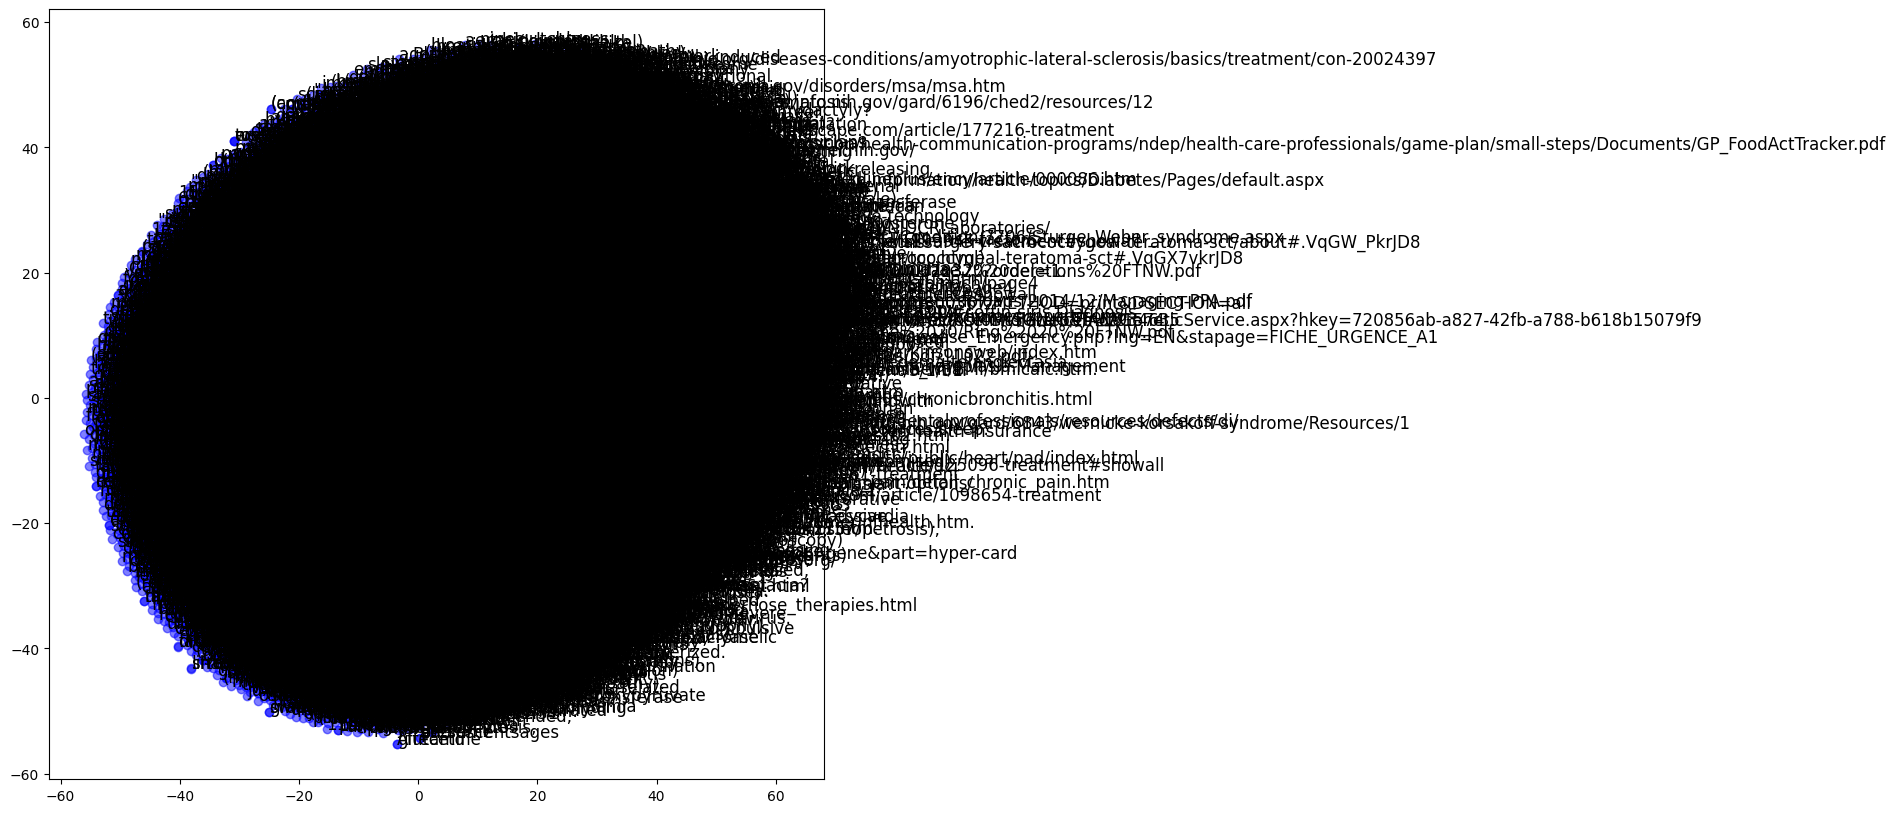

In [27]:
# Let's plot the 2D embeddings

def plot_with_labels(embeddings, labels):
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', alpha=0.5)
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), fontsize=12)
    plt.show()
plot_with_labels(word_embeddings_2d, idx_to_word.values())